In [1]:
import zipfile
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('./kaggle/working/')

['.ipynb_checkpoints', 'plates.zip']


In [3]:
data_root = './kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [4]:
import shutil
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name),
                    os.path.join(dest_dir, file_name))


100%|██████████| 21/21 [00:00<00:00, 866.90it/s]


In [5]:
# TRANSFORMS
import torch
import torchvision
import matplotlib.pyplot as plt
# import time
import copy
import random
from torchvision import transforms, models
import io

np.random.seed(123456789)
random.seed(123456789)
torch.cuda.manual_seed(123456789)
torch.random.manual_seed(123456789)
torch.manual_seed(123456789)
torch.backends.cudnn.deterministic = True

num_epochs = 1000
img_size = 220
step = 55
size = 300

train_transforms = transforms.Compose([
    #     *[transforms.RandomResizedCrop(224)  for _ in range(1)],
    # 0.7983870967741935 ep 50
    transforms.CenterCrop(img_size),
    # 0.7997311827956989 ep 100
    # 0.7983870967741935 ep 300

    transforms.Resize((size, size)),
    #     transforms.Resize((224, 224)),
    #     transforms.Resize(size=random.randint(50,224)), # 0.7190860215053764 ep 50
    #     transforms.RandomPosterize(bits=3),             # 0.7204301075268817 ep 50
    #     transforms.RandomInvert(),                      # 0.7298387096774194 ep 50
    #     transforms.RandomHorizontalFlip(),              # 0.7311827956989247 ep 50
    #     transforms.RandomResizedCrop(224),              # 0.7661290322580645 ep 50
    transforms.RandomRotation(degrees=(0, 270)),    # 0.7741935483870968 ep 50
    # 0.7526881720430108 ep 50
    transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    # transforms.RandAugment(2),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)


In [6]:
len(train_dataloader), len(train_dataset), len(val_dataset)

(4, 32, 8)

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
print('X_batch.size=', (X_batch.size()), ' len(y_batch)=', len(y_batch))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

X_batch.size= torch.Size([8, 3, 300, 300])  len(y_batch)= 8


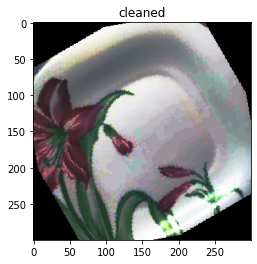

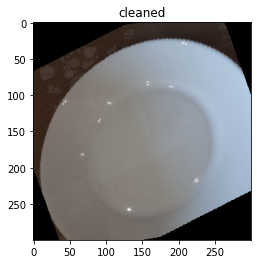

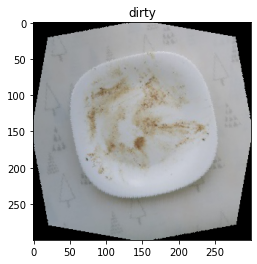

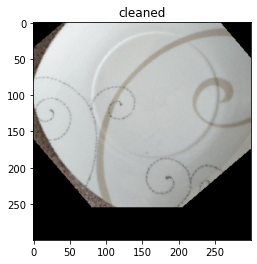

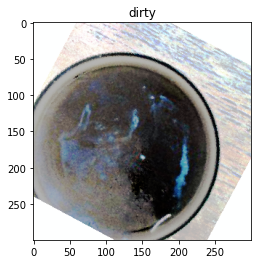

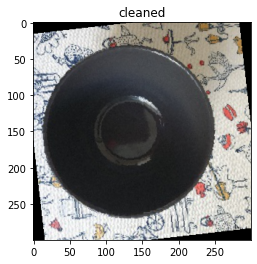

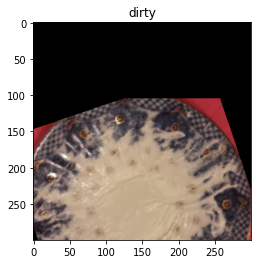

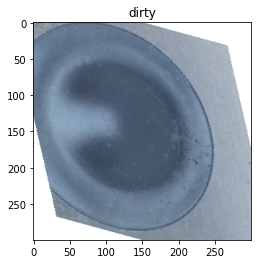

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = (std * image + mean).clip(0.0, 1.0)
    plt.imshow(image)
    plt.title(title)
    plt.show()
    plt.pause(0.001)


# for i in range(len(train_dataloader)):
#     print("batch # ",i)
# for X_batch, y_batch in (iter(train_dataloader)):
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])


In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    epoch_losses_train = []
    epoch_acces_train = []
    epoch_losses_val = []
    epoch_acces_val = []
    epoch_max = 1
    acc_loss_min = -1
    loss_best = 1
    loss_min = 1
    acc_max = 0
    best_model_state = copy.deepcopy(model.state_dict())
    for epoch in tqdm(range(num_epochs)):
        #         print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        if epoch >= (epoch_max+step):
            #             print('Best Epoch {}, loss {:.4f}, acc: {:.4f}:'.format(epoch_max, acc_loss_min, acc_max), flush=True)
            break

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:  # tqdm(
                #                 for x_item, y_item in zip(inputs, labels):
                #                     show_input(x_item, title=class_names[y_item])
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class ==
                                labels.data).float().mean().cpu()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                epoch_losses_train.append(epoch_loss)
                epoch_acces_train.append(epoch_acc)
            else:
                epoch_losses_val.append(epoch_loss)
                epoch_acces_val.append(epoch_acc)
#                 if acc_loss_min>epoch_loss:
                # (epoch_acc-epoch_loss)>acc_loss_min loss_best>epoch_loss
                if (epoch_acc-epoch_loss) > acc_loss_min and epoch > 5:
                    acc_loss_min = epoch_acc-epoch_loss
                    epoch_max = epoch
                    acc_max = epoch_acc
                    loss_best = epoch_loss
                    best_model_state = copy.deepcopy(model.state_dict())
                    print('Best ass-loss Epoch {}, loss {:.4f},  acc: {:.4f}:'.format(
                        epoch_max, loss_best, acc_max), flush=True)
                # (epoch_acc-epoch_loss)>acc_loss_min loss_best>epoch_loss
                if epoch_loss < loss_min and epoch > 5:
                    loss_min = epoch_loss
                    loss_epoch_max = epoch
                    print('Best loss Epoch {}, loss {:.4f},  acc: {:.4f}:'.format(
                        loss_epoch_max, loss_min, epoch_acc), flush=True)
#                     model_max = model

    print('Last epoch: {} Loss: {:.4f} Acc: {:.4f}'.format(
        epoch, epoch_loss, epoch_acc), flush=True)
    model.load_state_dict(best_model_state)
    return model, epoch_losses_train, epoch_losses_val, epoch_acces_train, epoch_acces_val


In [10]:
# resnext50_32x4d efficientnet_b3 regnet_x_16gf
model = models.regnet_x_16gf(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device=', device)
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


device= cuda:0


In [11]:
# TRAINING

model, epoch_losses_train, epoch_losses_val, epoch_acces_train, epoch_acces_val = \
    train_model(model, loss, optimizer, scheduler, num_epochs=num_epochs)


  1%|          | 6/1000 [00:09<24:15,  1.46s/it]

Best ass-loss Epoch 6, loss 0.6148,  acc: 0.6250:
Best loss Epoch 6, loss 0.6148,  acc: 0.6250:


  1%|          | 8/1000 [00:12<24:55,  1.51s/it]

Best ass-loss Epoch 8, loss 0.6176,  acc: 0.7500:


  1%|          | 9/1000 [00:13<25:26,  1.54s/it]

Best ass-loss Epoch 9, loss 0.6088,  acc: 0.7500:
Best loss Epoch 9, loss 0.6088,  acc: 0.7500:


  1%|          | 10/1000 [00:15<26:02,  1.58s/it]

Best ass-loss Epoch 10, loss 0.6045,  acc: 0.7500:
Best loss Epoch 10, loss 0.6045,  acc: 0.7500:


  1%|          | 11/1000 [00:16<25:36,  1.55s/it]

Best ass-loss Epoch 11, loss 0.6015,  acc: 0.7500:
Best loss Epoch 11, loss 0.6015,  acc: 0.7500:


  1%|          | 12/1000 [00:18<25:39,  1.56s/it]

Best ass-loss Epoch 12, loss 0.5990,  acc: 0.7500:
Best loss Epoch 12, loss 0.5990,  acc: 0.7500:


  1%|▏         | 13/1000 [00:20<25:45,  1.57s/it]

Best ass-loss Epoch 13, loss 0.5968,  acc: 0.8750:
Best loss Epoch 13, loss 0.5968,  acc: 0.8750:


  2%|▏         | 16/1000 [00:24<24:38,  1.50s/it]

Best loss Epoch 16, loss 0.5951,  acc: 0.6250:


  2%|▏         | 20/1000 [00:30<24:07,  1.48s/it]

Best loss Epoch 20, loss 0.5944,  acc: 0.7500:


  7%|▋         | 68/1000 [01:40<23:02,  1.48s/it]

Last epoch: 68 Loss: 0.6039 Acc: 0.7500


losses_val=0.594357967376709


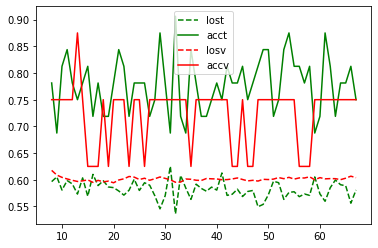

In [12]:
x = [i for i in range(len(epoch_losses_train))]
line_lt, = plt.plot(x[8:], epoch_losses_train[8:], '--g', label='lost')
line_at, = plt.plot(x[8:], epoch_acces_train[8:], '-g', label='acct')
line_lv, = plt.plot(x[8:], epoch_losses_val[8:], '--r', label='losv')
line_av, = plt.plot(x[8:], epoch_acces_val[8:], '-r', label='accv')
plt.legend(handles=[line_lt, line_at, line_lv, line_av])
print(f'losses_val={min(epoch_losses_val)}')
# , acces_val={epoch_acces_val}')


In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


test_dataset = ImageFolderWithPaths('./test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [14]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:, 1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)


In [15]:
preds


tensor([[-0.5845, -0.1638],
        [-0.2571, -0.3093],
        [-0.5433, -0.0432],
        [-0.3711,  0.0215],
        [-0.3847,  0.0431],
        [ 0.1584, -0.0084],
        [-0.1546,  0.0158],
        [-0.3828, -0.0955]], device='cuda:0')

In [ ]:
submission_df = pd.DataFrame.from_dict(
    {'id': test_img_paths, 'label': test_predictions})
# print(submission_df['label'])
submission_df['label'] = submission_df['label'].map(
    lambda pred: 'dirty' if float(pred) > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('./test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
# print(submission_df.head(n=6))
submission_df.to_csv('submission.csv')
